# Create `tfrec` Files From `h5` Files

This notebook is meant for transforming the `h5` files resulting from the dataset creation pipeline. This is done to produce datasets, that both include known parameters of the contained gravitational-waves for training of the filter and at the same time be in the format expected when training the detection network. This is done to later be able to use curriculum learning when training the detector and in general, for the dataset to be useful in this application.

The notebook includes the possibility of different pre-processing of the data, which is expected to contain time series of gravitational waves in detector noise from the two LIGO detectors and the Virgo detectors. The data processing pipeline later in the notebook is analogous to the one used when pre-processing the competition dataset.

The data can be:

* whitened
* highpassed
* bandpassed
* normalized

Additionally the ground truths can be whitened. This is not recommended when using a loss function like root mean squared error. whitening the signal causes a sharp spike at the time of coalescence and sets all other data points close to 0. This will cause the model to converge to a ill-posed solution that results in non-physical predictions.

In [1]:
import h5py
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import tensorflow as tf
from tqdm.notebook import tqdm
import gwpy
from gwpy.timeseries import TimeSeries
from scipy import signal

# tf.config.experimental.set_memory_growth()

In [2]:
INPUT_FILE = "../input/synthetic-h5/train_350_2_no_whiten_filter.h5"

Load the file and convert the relevant parts of the dataset to numpy arrays

In [3]:
with h5py.File(INPUT_FILE, "r") as f:
    injection_shape = f["injection_samples"]["h1_strain"].shape
    noise_shape = f["noise_samples"]["h1_strain"].shape
    
    injections_h1 = np.array(f["injection_samples"]["h1_strain"])
    ground_truths_h1 = np.array(f["injection_parameters"]["h1_signal"])
    noise_h1 = np.array(f["noise_samples"]["h1_strain"])
    
    injections_l1 = np.array(f["injection_samples"]["l1_strain"])
    ground_truths_l1 = np.array(f["injection_parameters"]["l1_signal"])
    noise_l1 = np.array(f["noise_samples"]["l1_strain"])
    
    injections_v1 = np.array(f["injection_samples"]["v1_strain"])
    noise_v1 = np.array(f["noise_samples"]["v1_strain"])
    ground_truths_v1 = np.array(f["injection_parameters"]["v1_signal"])
    

this cell can be used to get a better idea of the different SNRs of the dataset. Typically the SNR of the Virgo channel will be much lower than that of the LIGO channels. Especially in the last month of the O2 observation run, since that was the first month of operation for Virgo, leading to very poor resolution.

example of a gravitational wave contained in the dataset

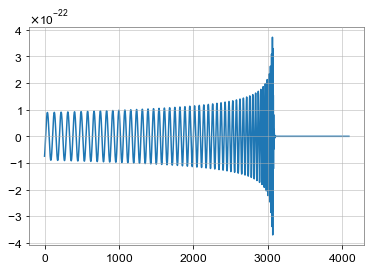

In [4]:
with h5py.File(INPUT_FILE, "r") as f:
    g_t = f["injection_parameters"]["h1_signal"][16]
plt.plot(g_t)


same wave, whitened

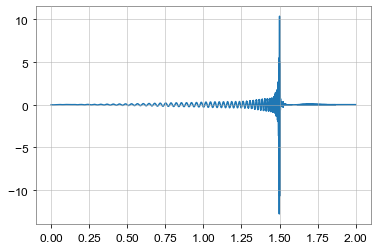

In [5]:
gt = TimeSeries(g_t, sample_rate=2048)
gt = gt.whiten(0.5,0.25)
plt.plot(gt)

In [6]:
if injection_shape[1] == noise_shape[1]:
    ds_shape = (injection_shape[0] + noise_shape[0], injection_shape[1],3)
    targets = np.zeros(ds_shape[0], dtype=np.uint8)
    timeseries = np.zeros(ds_shape)
    ground_truths = np.zeros(ds_shape)
    targets[:injection_shape[0]] = 1
    targets[injection_shape[0]:] = 0
    timeseries[:injection_shape[0],:,0] = injections_h1
    timeseries[injection_shape[0]:,:,0] = noise_h1
    ground_truths[:injection_shape[0],:,0] = ground_truths_h1
    timeseries[:injection_shape[0],:,1] = injections_l1
    timeseries[injection_shape[0]:,:,1] = noise_l1
    ground_truths[:injection_shape[0],:,1] = ground_truths_l1
    timeseries[:injection_shape[0],:,2] = injections_v1
    timeseries[injection_shape[0]:,:,2] = noise_v1
    ground_truths[:injection_shape[0],:,2] = ground_truths_v1
    
    
for i in tqdm(range(timeseries.shape[0])):
    timeseries[i] /= abs(timeseries[i]).max()

    

  0%|          | 0/100000 [00:00<?, ?it/s]

normalize the data

In [7]:
for i in tqdm(range(injection_shape[0])):
    ground_truths[i] /= abs(ground_truths[i]).max()

  0%|          | 0/50000 [00:00<?, ?it/s]

### Processing Pipeline Analogous to Competition Data

The following cell contains an analogous pre-processing pipeline as the one present in `makeDataset.py`. This is done so the same pre-processing steps, necessitated by the 2s time window in the competition data can be used on both datasets, so that the filters trained using datasets resulting from this pipeline will generalize more reliably to the competition data.

In [8]:
def bandpass(x, lf=20, hf=500, order=8, sr=2048):
    sos = signal.butter(order, [lf,hf], btype="bandpass", output="sos", fs=sr)
    normalization = np.sqrt((hf-lf) / (sr/2))
    if x.ndim == 2:
        for i in range(3):
            x[i] = signal.sosfilt(sos,x[i]) * normalization
    elif x.ndim == 3:
        for i in range(x,shape[0]):
            for j in range(3):
                x[i,j] = signal.sosfilt(sos,x[i,j]) * normalization
    return x


def highpass(x, lf=20, order=16, sr=2048):
    sos = signal.butter(order, lf, btype="highpass", output="sos", fs=sr)
    normalization = np.sqrt((2048-lf) / (sr/2))
    if x.ndim == 2:
        for i in range(3):
            x[i] = signal.sosfilt(sos,x[i]) * normalization
    elif x.ndim == 3:
        for i in range(x,shape[0]):
            for j in range(3):
                x[i,j] = signal.sosfilt(sos,x[i,j]) * normalization
    return x

def prepare_wave(wave):
    normalized_waves = []
    scaling = np.array([1.5e-20,1.5e-20,0.5e-20], dtype = np.float32)
    for i in range(3):
        normalized_wave= wave[i] / scaling[i]
        normalized_waves.append(normalized_wave)
    wave = np.stack(normalized_waves, axis=0)
    return wave

import gwpy
from gwpy.timeseries import TimeSeries
# from scipy.cluster.vq import whiten
# from gwpy.signal import filter_design
# from scipy import signal

def save_files(array):
    all_data_x = np.zeros([array.shape[0],4096,3], dtype=np.float32)
#     all_data_y = np.zeros(len(rg_n), dtype=np.uint8)
#     filts=[]
    # for j in range(3):
        # bp = filter_design.bandpass(50,550, 2048)
#         if j == 2:
#             notch_freqs = (50, 100, 150)
#         else:
#             notch_freqs = (60, 120, 180)
#         notches = [filter_design.notch(line, 2048) for line in notch_freqs]
#         zpk = filter_design.concatenate_zpks(bp, *notches)
#         filts.append(zpk)

    for index in tqdm(range(array.shape[0])):
    
#         pth, ident, target = slc.iloc[index][["path", "id", "target"]]
#         ids.append(ident)
#         all_data_y[index] = target
#         ts_data = np.load(pth)
        ts_data = array[index]
        ts_data = np.transpose(ts_data, [1,0])

        ts_data = prepare_wave(ts_data)

#         ts_data = bandpass(ts_data)
#         print(ts_data.shape)
        for i in range(3):
            measurement = ts_data[i]
            ts = TimeSeries(measurement)
            ts.sample_rate = 2048


#             zpk = filts[i]
# #             ts = ts.filter(zpk, filtfilt=True)
            ts = ts.whiten(0.125, 0.12)
            ts_data[i] = np.array(ts)
        ts_data = highpass(ts_data)

        ts_data = np.transpose(ts_data, [1,0])
        ts_data /= abs(ts_data).max()
#         ts_data = ts_data * -1
        ts_data = ts_data.astype(np.float32)
        all_data_x[index] = ts_data


    return all_data_x

In [9]:
timeseries = save_files(timeseries)

  0%|          | 0/100000 [00:00<?, ?it/s]

### Create `tfrec` Files

This is also done in an analogous way to the datasets created by `makeDataset.py`, to use them interchangeably.

In [10]:
batches = 8
batch_size = timeseries.shape[0] // batches
indices = np.arange(targets.shape[0])
np.random.shuffle(indices)
for i in tqdm(range(batches)):
    rg_n = range(i*batch_size,(i+1)*batch_size)
    inds = indices[rg_n]
    output_file = f"../input/synthetic-tfrec/{INPUT_FILE.split('/')[-1].replace('.h5','')}_{batch_size}_{i:02}.tfrec"
    writer = tf.io.TFRecordWriter(output_file)
    
    for j in tqdm(range(inds.shape[0])):
        X = timeseries[inds[j]]
        y = targets[inds[j]]
        y1 = ground_truths[inds[j]]
        feature={}
        feature["TimeSeries"] = tf.train.Feature(float_list=tf.train.FloatList(value=X.flatten()))
        feature["GroundTruths"] = tf.train.Feature(float_list=tf.train.FloatList(value=y1.flatten()))
        feature["Target"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[y]))

        example = tf.train.Example(features=tf.train.Features(feature=feature))
        serialized = example.SerializeToString()
        writer.write(serialized)
    writer.close()      


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]